In [1]:
%matplotlib inline

In [38]:
# Imports
import datetime
import gc
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import scipy.stats
import statsmodels.stats.proportion

import sklearn
import sklearn.dummy
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.preprocessing

# Setups
seaborn.set_style("darkgrid")

In [3]:
# Read in data
scdb_data = pandas.read_csv("../data/input/SCDB_2015_03_justiceCentered_Docket.csv.gz", encoding="iso-8859-1")

In [4]:
print (scdb_data.shape)

(90340, 61)


In [6]:
# Add date delay
decision_date = pandas.to_datetime(scdb_data.loc[:, "dateDecision"])
argument_date = pandas.to_datetime(scdb_data.loc[:, "dateArgument"])
scdb_data.loc[:, "argumentLag"] = (decision_date - argument_date) / numpy.timedelta64(1, 'D')
scdb_data.loc[:, "argumentMonth"] = decision_date.apply(lambda x: x.month)
scdb_data.loc[:, "decisionMonth"] = decision_date.apply(lambda x: x.month)

In [123]:
# Build feature data
categorical_feature_list = ["petitioner", "respondent",
                           "jurisdiction", "certReason", "adminAction",
                            "caseOrigin", #"caseSource",
                            "lcDisposition", "lcDispositionDirection",
                            "issueArea", "issue",
                            "justice",
                            "naturalCourt",
                            "argumentMonth", "decisionMonth",
                            ]
binary_feature_list = ["threeJudgeFdc", "lcDisagreement", "argumentLag",
                      ]
feature_list = []
feature_list.extend(categorical_feature_list)
feature_list.extend(binary_feature_list)

# Subset features
raw_feature_df = scdb_data.loc[:, feature_list].fillna(999999).astype(numpy.int32)

In [124]:
# Build target variable
SCDB_OUTCOME_MAP=None

def get_outcome_map():
    """
    Get the outcome map to convert an SCDB outcome into
    an affirm/reverse/other mapping.
    
    Rows correspond to vote types.  Columns correspond to disposition types.

    Element values correspond to:
    * -1: no precedential issued opinion or uncodable, i.e., DIGs
    * 0: affirm, i.e., no change in precedent
    * 1: reverse, i.e., change in precent
    """

    # Create map; see appendix of paper for further documentation
    outcome_map = pandas.DataFrame([[-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1]])
    outcome_map.columns = range(1, 12)
    outcome_map.index = range(1, 9)

    return outcome_map


def get_outcome(vote, disposition, outcome_map=SCDB_OUTCOME_MAP):
    """
    Return the outcome code based on outcome map.
    """
    if not outcome_map:
        SCDB_OUTCOME_MAP=get_outcome_map()
        outcome_map = SCDB_OUTCOME_MAP

    if pandas.isnull(vote) or pandas.isnull(disposition):
        return -1
    
    return outcome_map.loc[int(vote), int(disposition)]

outcome_map = get_outcome_map()
scdb_data.loc[:, "case_outcome_disposition"] = outcome_map.loc[1, scdb_data.loc[:, "caseDisposition"]].values
scdb_data.loc[:, "lc_case_outcome_disposition"] = outcome_map.loc[1, scdb_data.loc[:, "lcDisposition"]].values

scdb_data.loc[:, "justice_outcome_disposition"] = scdb_data.loc[:, ("vote", "caseDisposition")] \
        .apply(lambda row: get_outcome(row["vote"], row["caseDisposition"]), axis=1)

In [9]:
# Setup target vector
target_vector = scdb_data.loc[:, "justice_outcome_disposition"].astype(numpy.int32).values

In [125]:
# Check shapes
print(raw_feature_df.shape)
print(target_vector.shape)
assert(raw_feature_df.shape[0] == target_vector.shape[0])

(90340, 17)
(90340,)


In [ ]:
# Setup training time period
min_training_years = 10
term_range = range(scdb_data["term"].min() + min_training_years,
                   scdb_data["term"].max()+1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 2

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Setup model
m = None
term_count = 0

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (scdb_data.loc[:, "term"] < term).values
    test_index = (scdb_data.loc[:, "term"] == term).values
    
    # Encode feature matrix for this term out of sample
    feature_encoder = sklearn.preprocessing.OneHotEncoder(n_values="auto", categorical_features=range(len(categorical_feature_list)), 
                                        dtype=numpy.int32, sparse=False, handle_unknown="ignore")
    train_raw_feature_df = scdb_data.loc[train_index, feature_list].fillna(999999).astype(numpy.int32)
    test_raw_feature_df = scdb_data.loc[test_index, feature_list].fillna(999999).astype(numpy.int32)
    feature_data_train = feature_encoder.fit_transform(train_raw_feature_df)
    feature_data_test = feature_encoder.transform(test_raw_feature_df)
    print(feature_data_train.shape)
    
    # Setup train data
    target_data_train = scdb_data.loc[train_index, "justice_outcome_disposition"].astype(numpy.int16).values

    # Setup test data
    target_data_test = scdb_data.loc[test_index, "justice_outcome_disposition"].astype(numpy.int16).values
    
    # Fit
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_data_train, target_data_train)
    m = sklearn.pipeline.Pipeline([
            #("interact", sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=False)),
            ("feature_select_1", sklearn.feature_selection.SelectFromModel(sklearn.ensemble.ExtraTreesClassifier(n_estimators=100),
                                                                          threshold="median")),
            ("classify", sklearn.ensemble.RandomForestClassifier(n_estimators=1000))
        ])
    m.fit(feature_data_train, target_data_train)
    
    # Predict next term
    scdb_data.loc[test_index, "rf_model_predicted"] = m.predict(feature_data_test)
    scdb_data.loc[test_index, "dummy_model_predicted"] = d.predict(feature_data_test)
    
    # Output classification report
    #print(sklearn.metrics.classification_report(target_data_test, scdb_data.loc[test_index, "rf_model_predicted"]))
    #print(sklearn.metrics.f1_score(target_data_test, scdb_data.loc[test_index, "rf_model_predicted"], average="weighted"))
    print((sklearn.metrics.accuracy_score(target_data_test, scdb_data.loc[test_index, "rf_model_predicted"]),
           sklearn.metrics.accuracy_score(target_data_test, scdb_data.loc[test_index, "dummy_model_predicted"]),
           ))
    
    # Cleanup
    del feature_data_train
    del feature_data_test
    del m
    gc.collect()

Term: 1956
(12366, 695)
(0.63492063492063489, 0.55634920634920637)
Term: 1957
(13626, 715)
(0.64912280701754388, 0.57602339181286555)
Term: 1958
(15336, 730)
(0.65387205387205383, 0.52390572390572387)
Term: 1959
(16821, 750)
(0.67476085356880056, 0.58719646799116998)
Term: 1960
(18180, 765)
(0.58527954706298657, 0.50247699929228595)
Term: 1961
(19593, 778)
(0.61946202531645567, 0.55379746835443033)
Term: 1962
(20857, 789)
(0.7030965391621129, 0.6690953248330298)
Term: 1963
(22504, 798)
(0.70801033591731266, 0.66149870801033595)
Term: 1964
(24439, 804)
(0.65684830633284241, 0.59057437407952873)
Term: 1965
(25797, 812)
(0.69587301587301587, 0.61777777777777776)
Term: 1966
(27372, 830)
(0.68852459016393441, 0.61870066788099576)
Term: 1967
(29019, 837)
(0.63393626184323859, 0.61240310077519378)
Term: 1968
(31341, 854)
(0.68403693931398413, 0.59696569920844322)
Term: 1969
(32857, 868)
(0.60014619883040932, 0.53728070175438591)
Term: 1970
(34225, 879)
(0.6542483660130719, 0.50653594771241828

In [128]:
# Evaluation range
evaluation_index = scdb_data.loc[:, "term"].isin(term_range)
target_actual = scdb_data.loc[evaluation_index, "justice_outcome_disposition"]
target_predicted = scdb_data.loc[evaluation_index, "rf_model_predicted"]
target_dummy = scdb_data.loc[evaluation_index, "dummy_model_predicted"]
scdb_data.loc[:, "rf_correct"] = numpy.nan
scdb_data.loc[:, "dummy_correct"] = numpy.nan
scdb_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
scdb_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.91      0.49      0.64      7429
          0       0.59      0.34      0.43     25991
          1       0.66      0.87      0.75     44554

avg / total       0.66      0.66      0.63     77974

[[ 3651   625  3153]
 [  139  8924 16928]
 [  244  5688 38622]]
0.656590658425

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      7429
          0       0.00      0.00      0.00     25991
          1       0.57      1.00      0.73     44554

avg / total       0.33      0.57      0.42     77974

[[    0     0  7429]
 [    0     0 25991]
 [    0     0 44554]]
0.571395593403



/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


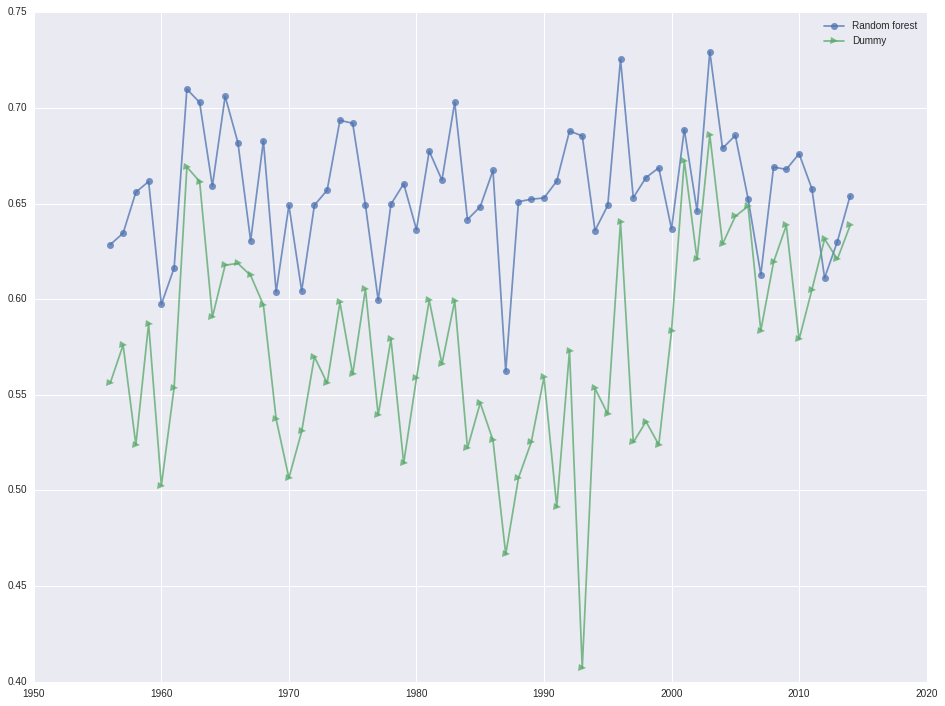

In [130]:
# Setup time series
rf_correct_ts = scdb_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = scdb_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

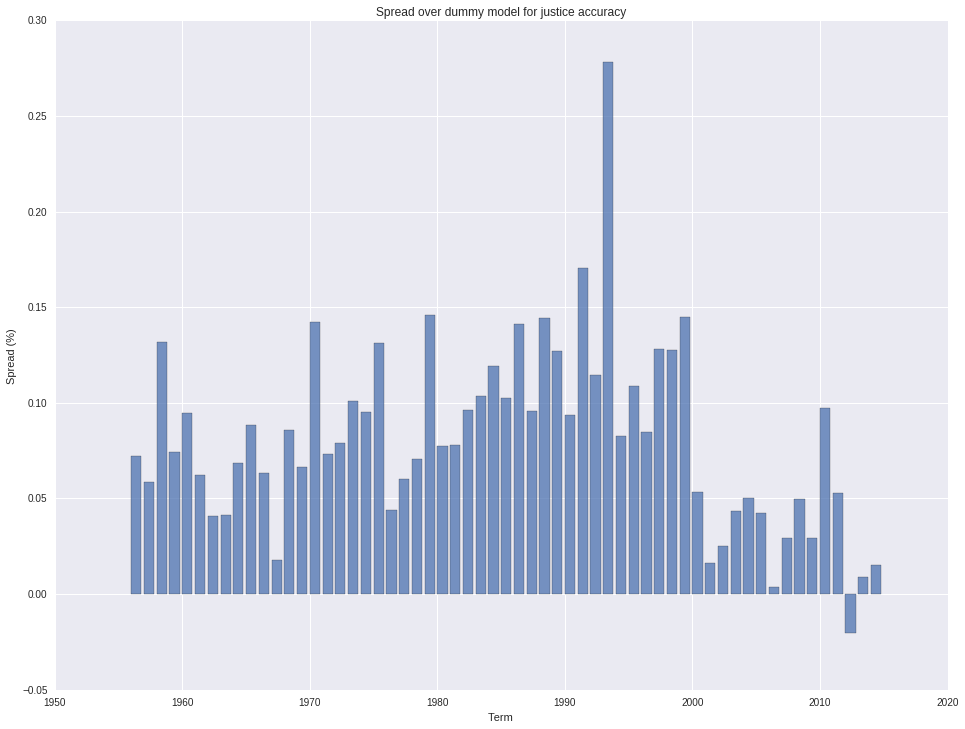

In [131]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [132]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(scdb_data.loc[evaluation_index, "rf_correct"].sum(),
                                              scdb_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              scdb_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=12.797742961345319, pvalue=1.5459405604265405e-18)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=7.537863068104687, pvalue=4.7773510490429202e-14)
Binomial:
0.0


In [133]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(scdb_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_model_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(scdb_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_model_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = scdb_data[["docketId", "case_outcome_disposition", "rf_model_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = scdb_data[["docketId", "dummy_model_predicted"]].join(dummy_predicted_case, on="docketId")

scdb_data.loc[:, "rf_predicted_case"] = rf_predicted_case
scdb_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [134]:
# Output case distribution
case_outcomes = scdb_data.groupby(["docketId"])["case_outcome_disposition"].apply(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

 1    6266
 0    3135
-1     541
dtype: int64
 1    0.630255
 0    0.315329
-1    0.054416
dtype: float64


In [135]:
# Output comparison
# Evaluation range
evaluation_index = scdb_data.loc[:, "term"].isin(term_range) & -scdb_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = scdb_data.loc[evaluation_index, "case_outcome_disposition"]
target_predicted = scdb_data.loc[evaluation_index, "rf_predicted_case"]
target_dummy = scdb_data.loc[evaluation_index, "dummy_predicted_case"]

scdb_data.loc[:, "rf_correct_case"] = numpy.nan
scdb_data.loc[:, "dummy_correct_case"] = numpy.nan
scdb_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
scdb_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

       -1.0       0.92      0.59      0.72      4049
        0.0       0.52      0.23      0.32     22856
        1.0       0.70      0.90      0.79     49858

avg / total       0.66      0.69      0.65     76763

[[ 2409   126  1514]
 [   36  5368 17452]
 [  180  4831 44847]]
0.685538605839

Dummy model
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00      4049
        0.0       0.00      0.00      0.00     22856
        1.0       0.65      1.00      0.79     49858

avg / total       0.42      0.65      0.51     76763

[[    0     0  4049]
 [    0     0 22856]
 [    0     0 49858]]
0.649505621198



/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


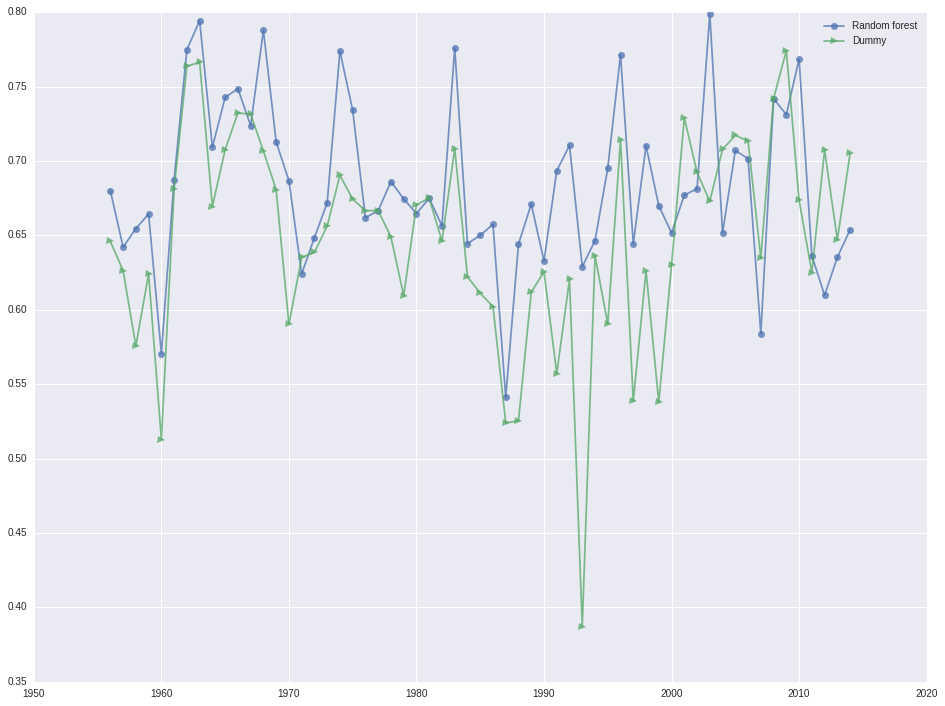

In [136]:
# Setup time series
rf_correct_case_ts = scdb_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = scdb_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

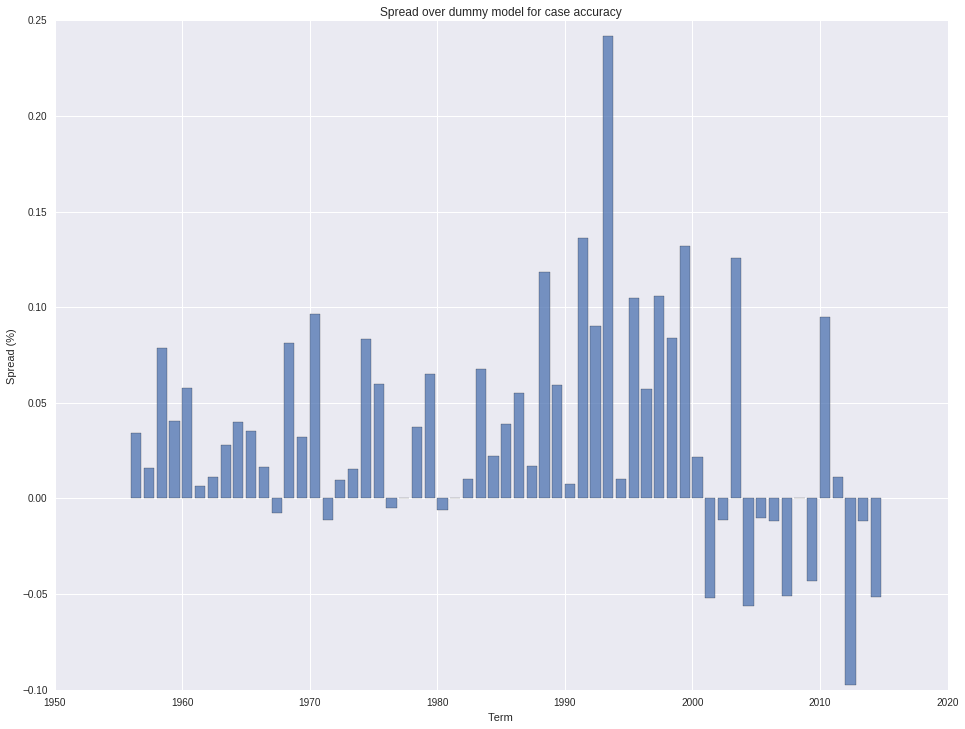

In [137]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


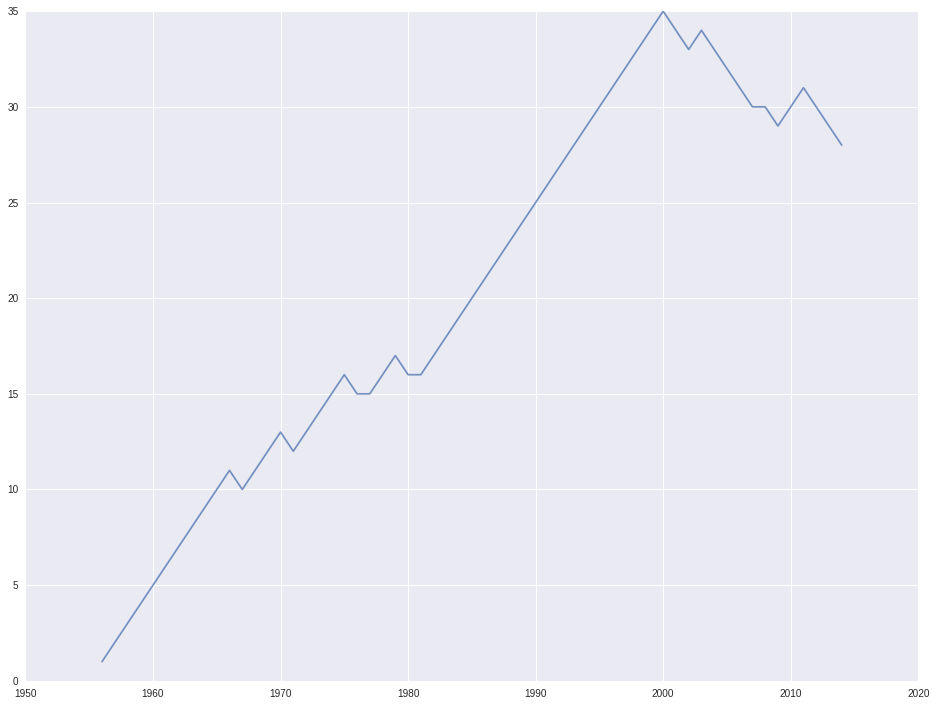

In [138]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)